# 5. Deep Learning Computation

## 5.1 Layers and Blocks

In this chapter, we will peel back the curtain, digging deeper into the key components of deep learning computation, namely **model construction**, **parameter access and initialization**, **designing custom layers and blocks**, **reading and writing models to disk**, and **leveraging GPUs to achieve dramatic speedups**.

In [ ]:
!pip install d2l==0.14.2

In [3]:
import torch
from torch import nn
from torch.nn import functional as F

the concept of a neural network *block*.
A block could describe a single layer, a component consisting of multiple layers, or the entire model itself!
One benefit of working with the block abstraction is that they can be combined into larger artifacts, often recursively.

The following code generates a network with one fully-connected hidden layer with 256 units and ReLU activation, followed by a fully-connected output layer with 10 units(no ativation function).

In [4]:
net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))

In [5]:
X = torch.rand(2, 20)

In [6]:
net(X)

tensor([[-0.0105,  0.1099, -0.1435, -0.2687,  0.1066,  0.0962,  0.0775, -0.0327,
         -0.0546, -0.1029],
        [-0.0261,  0.1240, -0.1577, -0.3801, -0.0700,  0.0934,  0.0618, -0.0407,
         -0.1943,  0.0500]], grad_fn=<AddmmBackward0>)

In short, nn.Sequential defines a special kind of Module, the class that presents a block in PyTorch.
It maintains an ordered list of constituent Modules.
Note that each of the two fully-connected layers is an instance of the Linear class which is itself a subclass of Module.

Before we implement our own custom block, we briefly summarize the basic functionality that each block must provide:
1. Ingest input data as arguments to its forward propagation function.
2. Generate an output by having the forward propagation function return a value. Note that the output may have a different shape from the input. For example, the first fully-connected layer in our model above ingests an input of dimension 20 but returns an output of dimension 256.
3. Calculate the gradient of its output with respect to its input, which can be accessed via its backpropagation function. Typically this happens automatically.
4. Store and provide access to those parameters necessary to execute the forward propagation computation.
5. Initialize model parameters as needed.


In [7]:
class MLP(nn.Module):
  # Declare a layer with model parameters. Here, we declare two fully connected layers
  def __init__(self):
    # Call the constructor of the `MLP` parent class `Module` to perform the necessary initialization.
    # In this way, other function arguments can also be specified during class instantiation, such as the model parameters, `params` (to be described later)
    super().__init__()
    self.hidden = nn.Linear(20, 256) # Hidden layer
    self.out = nn.Linear(256, 10) # Output layer

  # Define the forward propagation of the model, that is, how to return the required model output based on the input `X`
  def forward(self, X):
    # Note here we use the functional version ReLU defined in the nn.functional module.
    return self.out(F.relu(self.hidden(X)))

Note that it takes X as the input, calculates the hidden representation with the activation function applied, and outputs its logits.
In this MLP implementation, both layers are instance variables.
To see why this is reasonable, imagine instantiating two MLPs, net1 and net2, and training them on different data.
Naturally, we would expect them to represent two different learned models.

Note that unless we implement a new operator, we need not worry about the backpropagation function or parameter initialization. The system will generate these functions automatically.

In [8]:
net = MLP()
net(X)

tensor([[ 0.1366, -0.0934,  0.0124, -0.1049, -0.0462, -0.0049, -0.4104, -0.0616,
         -0.0580, -0.0597],
        [ 0.0501, -0.1042, -0.0759, -0.1686,  0.0723,  0.0270, -0.3685,  0.0066,
         -0.0806, -0.1850]], grad_fn=<AddmmBackward0>)

A key virtue of the block abstraction is its versatility. We can subclass a block to create layers (such as the fully-connected layer class), entire models (such as MLP class above), or various components of intermediate complexity.

In [9]:
# we can now take a closer look at how the Sequential class works.
# two key function : 1. A function to append blocks one by one to a list.
# 2. A forward propagation function to pass an input through the chain of blocks, in the same order as they were appended.

In [10]:
class MySequential(nn.Module):
  def __init__(self, *args):
    super().__init__()
    for idx, module in enumerate(args):
      # Here, `module` is an instance of a `Module` subclass.
      # We save it in the member variable `_modules` of the `Module` class, and its type is OrderedDict
      self._modules[str(idx)] = module
      # you might wonder why every Module possesses a _modules attribute and why we used it rather than just define a Python list ourselves.
      # In short the chief advanatge of _modules is that during our module's parameter initialization,
      # the system knows to look inside the _modules dictionary to find sub-modules whose parameters also need to be initialized.
  def forward(self, X):
    # OrderedDict guarantees that memebers will be traversed in the order they were added.
    for block in self._modules.values():
      X = block(X)
    return X

In [11]:
net = MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
net(X)

tensor([[ 0.0479, -0.2129, -0.0379, -0.0908,  0.1511,  0.2889, -0.2433, -0.1504,
          0.3012,  0.0038],
        [ 0.0357, -0.1925, -0.1861,  0.0565,  0.1230,  0.2560, -0.2437, -0.2908,
          0.1156, -0.0956]], grad_fn=<AddmmBackward0>)

When greater flexibility is required, we will want to define our own blocks.
For example, we might want to execute Python's control flow within the forward propagation function.
Moreover, we might want to perform arbitrary mathematical operations, not simply relying on predefined neural network layers.
Sometimes, however, we might want to incorporate terms that are neither the result of previous layers nor updatable parameters.

In [14]:
class FixedHiddenMLP(nn.Module):
  def __init__(self):
    super().__init__()
    # Random weight parameters that will not compute gradients and therefore keep constant during training
    self.rand_weight = torch.rand((20, 20), requires_grad = False)
    self.linear = nn.Linear(20, 20)
  
  def forward(self, X):
    X = self.linear(X)
    # Use the created constant parameters, as well as the `relu` and `mm` functions
    X = F.relu(torch.mm(X, self.rand_weight) + 1)
    # Reuse the fully-connected layer. This is equivalent to sharing parameters with two fully-connected layers
    X = self.linear(X)
    # Control flow
    while X.abs().sum() > 1: # testing on the condition its L1 norm is larger than 1
      X /= 2 # 왼쪽 변수에 오른쪽 값을 나누고 그 결과를 왼쪾 변수에 할당 ex. a /= b <=> a = a/b
    return X.sum()

Note that this particular operation may not be useful in any real-world task. Our point is only to show you how to integrate arbitrary code into the flow of your neural network computations.

In [15]:
net = FixedHiddenMLP()
net(X)

tensor(-0.2058, grad_fn=<SumBackward0>)

In [18]:
class NestMLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(20, 64), nn.ReLU(), nn.Linear(64, 32), nn.ReLU())
    self.linear = nn.Linear(32, 16)

  def forward(self, X):
    return self.linear(self.net(X))


In [19]:
chimera = nn.Sequential(NestMLP(), nn.Linear(16, 20), FixedHiddenMLP())
chimera(X)

tensor(0.1079, grad_fn=<SumBackward0>)

## Summary
* Layers are blocks
* Many layers can comprise a block.
* Many blocks can comprise a block.
* A block can contain code.
* Blocks take care of lots of housekeeping, including parameter initialization and backpropagation.
* Sequential concatenations of layers and blocks are handled by the *Sequential* block.

## 5.2 Parameter Management

Once we have chosen an architecture and set our hyperparameters, we proceed to the training loop, where our goal is to find parameter values that minimize our loss function.

In this section, we cover the following:
* Accessing parameters for debugging, diagnostics, and visualizations.
* Parameter initialization.
* Sharing parameters across different model components.

In [20]:
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size = (2,4))
net(X)

tensor([[0.4324],
        [0.4051]], grad_fn=<AddmmBackward0>)

In [22]:
# each layer's parameters are conveniently located in its attribute.
# We can inspect the parameters of the second fully-connected layers as follows.
print(net[2].state_dict())

OrderedDict([('weight', tensor([[-0.3007, -0.1463,  0.1335,  0.2865,  0.3052, -0.1386,  0.3373, -0.1939]])), ('bias', tensor([0.1736]))])


In [24]:
# The following code extracts the bias from the second neural network layer,
# which returns a parameter class instance, and further accesses that parameter's value.
print(type(net[2].bias))
print(net[2].bias)
print(net[2].bias.data)

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([0.1736], requires_grad=True)
tensor([0.1736])


In [25]:
# In addition to the value, each parameter also allows us to access the gradient.
# Because we have not invoked backpropagation for this network yet, it is in its initial state.
net[2].weight.grad == None

True

In [26]:
# Below we demonstrate accessing the parameters of the first fully-connected layer vs. accessing all layers.
print(*[(name, param.shape) for name, param in net[0].named_parameters()])
print(*[(name, param.shape) for name, param in net.named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


In [27]:
net.state_dict()['2.bias'].data

tensor([0.1736])

In [28]:
# Collecting Parameters from Nested Blocks
def block1():
  return nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                       nn.Linear(8, 4), nn.ReLU())
  
def block2():
  net = nn.Sequential()
  for i in range(4):
    # Nested here
    net.add_module(f'block {i}', block1())
  return net

In [29]:
rgnet = nn.Sequential(block2(), nn.Linear(4,1))
rgnet(X)

tensor([[0.0950],
        [0.0954]], grad_fn=<AddmmBackward0>)

In [30]:
print(rgnet)

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


Since the layers are hierarchically nested, we can also access them as though indexing through nested lists. For instance, we can access the first major block, within it the second sub-block, and within that the bias of the first layer, with as follows.

In [31]:
rgnet[0][1][0].bias.data

tensor([ 0.4028,  0.2159, -0.2295,  0.0572, -0.0388,  0.4746,  0.4848,  0.4638])

By default, PyTorch initializes weight and bias matrices uniformly by drawing from a range that is computed according to the input and output dimension.
PyTorch's nn.init module provides a variety of prest initialization methods.

1. Built-in initialization
The code below initializes all weight parameters as Gaussian random variables with standard deviation 0.01, while bias parameters cleared to zero.

In [33]:
def init_normal(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, mean = 0, std = 0.01)
    nn.init.zeros_(m.bias)

net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([-0.0092, -0.0180, -0.0026,  0.0052]), tensor(0.))

In [34]:
# we can also initialize all the parameters to a given constant value (Say, 1)

def init_constant(m):
  if type(m) == nn.Linear:
    nn.init.constant_(m.weight, 1)
    nn.init.zeros_(m.bias)
net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

In [35]:
def xavier(m):
  if type(m) == nn.Linear:
    nn.init.xavier_uniform_(m.weight)
def init_42(m):
  if type(m) == nn.Linear:
    nn.init.constant_(m.weight, 42)
net[0].apply(xavier)
net[2].apply(init_42)

print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([ 0.4440, -0.0964,  0.4091, -0.4554])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


In [36]:
def my_init(m):
  if type(m) == nn.Linear:
    print("Init", *[(name, param.shape) for name, param in m.named_parameters()][0])
    nn.init.uniform_(m.weight, -10, 10)
    m.weight.data *= m.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[-5.2258, -7.9023,  0.0000, -5.3204],
        [ 0.0000, -0.0000,  0.0000, -7.0678]], grad_fn=<SliceBackward0>)

In [37]:
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.0000, -6.9023,  1.0000, -4.3204])

**Tied Parameters**


Often we want to share parameters across multiple layers. Let us see how to do this elegantly. In the following we allocate a dense layer and then use its parameters specifically to set those of another layer.

In [38]:
# We need to give the shared layer a name so that we can refer to its parameters
shared = nn.Linear(8, 8)
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.Linear(8, 1))
net(X)

tensor([[0.4508],
        [0.5046]], grad_fn=<AddmmBackward0>)

In [39]:
# Check whether the parameters are the same
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# Make sure that they are actually the same object rather than just having the same value
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


This example shows that the parameters of the second and third layer are tied.

They are not just equal, they are represented by the same exact tensor.

Thus, if we change one of the parameters, the other one changes, too.

You might wonder, when parameters are tied what happens to the grdients?

Since the model parameters contain gradients, the gradients of the second hidden layers and the third hidden layer are added together during backpropagation.

## Summary
* We have several ways to access, initialize, and tie model parameters.
* We can use custom initialization.

## 5.3 Custom Layers
One factor behind deep learning's success is the availability of a wide range of layers that can be composed in creative ways to design architectures suitable for a wide variety of tasks.

In [40]:
# layers without parameters
class CenteredLayer(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, X):
    return X - X.mean()

In [41]:
layer = CenteredLayer()
layer(torch.FloatTensor([1, 2, 3, 4, 5]))

tensor([-2., -1.,  0.,  1.,  2.])

In [42]:
net = nn.Sequential(nn.Linear(8, 128), CenteredLayer())

In [43]:
# As an extra sanity check, we can send random data through the network and check that the mean is in fact 0.
# Because we are dealing with floating point numbers, we may still see a very small nonzero number due to quantization.
Y = net(torch.rand(4, 8))
Y.mean()

tensor(4.6566e-09, grad_fn=<MeanBackward0>)

In [44]:
class MyLinear(nn.Module):
  def __init__(self, in_units, units):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(in_units, units))
    self.bias = nn.Parameter(torch.randn(units,))
  def forward(self, X):
    linear = torch.matmul(X, self.weight.data) + self.bias.data
    return F.relu(linear)

In [45]:
linear = MyLinear(5, 3)
linear.weight

Parameter containing:
tensor([[-0.4056, -0.5313, -0.8475],
        [ 0.4193,  0.4344, -0.3667],
        [-1.2689, -1.3412,  3.1326],
        [-1.6024,  0.1647,  0.4367],
        [ 0.5379, -0.2373,  0.3023]], requires_grad=True)

In [46]:
linear(torch.rand(2, 5))

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.1714, 0.7388]])

In [47]:
net = nn.Sequential(MyLinear(64, 8), MyLinear(8, 1))
net(torch.rand(2, 64))

tensor([[0.],
        [0.]])

## Summary
* We can design custom layers via the basic layer class. This allows us to define flexible new layers that behave differently from any existing layers in the library.

* Once defined, custom layers can be invoked in arbitrary contexts and architectures.

* Layers can have local parameters, which can be created through built-in functions.

## 5.4 File I/O
So far we discussed how to process data and how to **build, train, and test** deep learning models.

the learned models that we will want to save the reusults for later use in various contexts(to make predictions in deployment)

Additionally, when running a long training process, the best practice is to periodically save intermediate results(checkpointing)

**how to load and store both individual weight vectors and entire models.**

In [48]:
x = torch.arange(4)
torch.save(x, 'x-file')

In [49]:
x2 = torch.load('x-file')
x2

tensor([0, 1, 2, 3])

In [50]:
# we can store a list of tensors and read them back into memory.
y = torch.zeros(4)
torch.save([x, y], 'x-files')
x2, y2 = torch.load('x-files')
(x2, y2)

(tensor([0, 1, 2, 3]), tensor([0., 0., 0., 0.]))

In [52]:
# we can even write and read a dictionary that maps from strings to tensors.
# This is convenient when we want to read or write all the weights in a model.
mydict = {'x':x, 'y':y}
torch.save(mydict, 'mydict')
mydict2 = torch.load('mydict')
mydict2

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

The deep learning framework provides built-in functionalities to load and save entire networks. An important detail to note is that this saves model *parameters* and not the entire model.

In [53]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden = nn.Linear(20, 256)
    self.output = nn.Linear(256, 10)
  
  def forward(self, x):
    return self.output(F.relu(self.hidden(x)))

In [54]:
net = MLP()
X = torch.randn(size = (2, 20))
Y = net(X)

In [55]:
torch.save(net.state_dict(), 'mlp.params')

In [56]:
clone = MLP()
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()
# Instead of randomly initializing the model parameters, we read the parameters stored in the file directly.

MLP(
  (hidden): Linear(in_features=20, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

In [57]:
Y_clone = clone(X)
Y_clone == Y

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])

## Summary
* The *save* and *load* functions can be used to perform file I/O for tensor objects.
* We can save and load the entire sets of parameters for a network via a parameter dictionary.
* Saving the architecture has to be done in code rather than in parameters.

## 5.5 GPUs
In this section, we begin to discuss how to harness this computational performance for your research.

First by using single GPUs and at a later point, how to use multiple GPUs and multiple servers (with multiple GPUs).

This is simply to illustrate how data flow between different devices.

In [3]:
import torch
from torch import nn

It should be noted that the cpu device means all physical CPUs and memory.
This means that PyTorch's calculations will try to use all CPU cores. However, a gpu device only represents one card and the corresponding memory.

In [4]:
torch.device('cpu'), torch.device('cuda'), torch.device('cuda:1')

(device(type='cpu'), device(type='cuda'), device(type='cuda', index=1))

In [5]:
# we can query the number of available GPUs.
torch.cuda.device_count()

1

In [12]:
def try_gpu(i=0):
  """Return gpu(i) if exists, otherwise return cpu()."""
  if torch.cuda.device_count() >= i+1:
    return torch.device(f'cuda:{i}')
  return torch.device('cpu')

def try_all_gpus():
  """Return all available GPUs, or [cpu(), ] if no GPU exists."""
  devices = [torch.device(f'cuda:{i}')
          for i in range(torch.cuda.device_count())]
  return devices if devices else [torch.device('cpu')]

try_gpu(), try_gpu(10)


(device(type='cuda', index=0), device(type='cpu'))

In [13]:
try_all_gpus()

[device(type='cuda', index=0)]

In [7]:
# By default, tensors are created on the CPU. We can query the device where the tensor is located.
x = torch.tensor([1, 2, 3])
x.device

device(type='cpu')

It is important to note that whenever we want to operate on multiple terms, they need to be on the same device.

For instance, if we sum two tensors, we need to make sure that both arguments live on the same device - otherwise, the framework would not know where to store the result or even how to decide where to perform the computation.

In [8]:
X = torch.ones(2, 3, device = try_gpu())
X

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')

In [15]:
# gpu 1개만 사용할 수 있는 환경
Y = torch.rand(2, 3, device = try_gpu(1))
Y

tensor([[0.7845, 0.4594, 0.4219],
        [0.0869, 0.9426, 0.8362]])

If we want to compute X + Y, we need to decide where to perform this operation.


Since Y lives on the second GPU, we need to move X there before we can add the two.

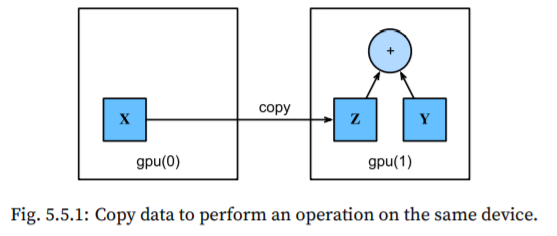

In [16]:
Z = X.cuda(1)
print(X)
print(Z)
# cuda:1이 없어서 안되는 걸로 판단됨.

RuntimeError: ignored

In [17]:
Y+Z

NameError: ignored

In [18]:
Z.cuda(1) is Z

NameError: ignored

People use GPUs to do machine learning because they expect them to be fast.

But transferring varaibles between device is slow.

In [19]:
# Similarly, a neural network model can specify devices
net = nn.Sequential(nn.Linear(3, 1))
net = net.to(device = try_gpu())

In [20]:
# When the input is a tensor on the GPU, the model will calculate the result on the same GPU.
net(X)

tensor([[1.1002],
        [1.1002]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [22]:
# Let us confirm that the model parameters are stored on the same GPU.
net[0].weight.data.device
# In short, as long as all data and parameters are on the same device, we can learn models efficiently

device(type='cuda', index=0)

## Summary
* We can specify devices for storage and calculation, such as the CPU or GPU. By default, data are created in the main memory and then use the CPU for calculations.

* The deep learning framework requires all input data for calculation to be on the same device, be it CPU or the same GPU.

* You can lose significant performance by moving data without care. A typical mistake is as follows: computing the loss for every minibatch on the GPU and reporting it back to the user on the command line(or logging it in a NumPy ndarray) will trigger a global interpreter lock which stalls all GPUs. It is much better to allocate memory for logging insdie the GPU and only move larger logs.